In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 18

Device: cuda:0


In [2]:
# Load data
images = np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000_image.npy")
labels = np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000_label.npy")

# Normalize image data.  0-255 to 0-1
images = images / 255
df = pd.DataFrame(np.concatenate((images, labels), axis=1))

# Rename the last column as "label"
df.rename(columns={784:"label"}, inplace=True)

# Convert label column to integer type
df['label'] = df['label'].astype('int64')

In [3]:
img = df.iloc[:, 0:-1]
lbl = df['label']

#Split dataset
x_train1, x_test, y_train1, y_test = train_test_split(img, lbl, test_size = 0.20, random_state = 123, stratify = lbl)
print(x_train1.shape)
print(y_train1.shape)

(276000, 784)
(276000,)


In [4]:
#Convert dataframe to tensor
x_train1 = torch.tensor(x_train1.values)
y_train1 = torch.tensor(y_train1.values)

x_test = torch.tensor(x_test.values)
y_test = torch.tensor(y_test.values)

In [5]:
#Create dataloaders
train_dataset = TensorDataset(x_train1, y_train1)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [6]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 784])
Image label dimensions: torch.Size([256])


In [7]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
    def encoder(self, x):
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        return encoded
    
    def decoder(self, encoded_x):
        logits = self.linear_2(encoded_x)
        decoded = torch.sigmoid(logits)
        return decoded
        

    def forward(self, x):
        ### ENCODER
        encoded = self.encoder(x)
        
        ### DECODER
        decoded = self.decoder(encoded)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
## Training
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).float().to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/1079 | Cost: 0.7179
Epoch: 001/005 | Batch 050/1079 | Cost: 0.3772
Epoch: 001/005 | Batch 100/1079 | Cost: 0.3297
Epoch: 001/005 | Batch 150/1079 | Cost: 0.3102
Epoch: 001/005 | Batch 200/1079 | Cost: 0.3037
Epoch: 001/005 | Batch 250/1079 | Cost: 0.2880
Epoch: 001/005 | Batch 300/1079 | Cost: 0.2895
Epoch: 001/005 | Batch 350/1079 | Cost: 0.2788
Epoch: 001/005 | Batch 400/1079 | Cost: 0.2827
Epoch: 001/005 | Batch 450/1079 | Cost: 0.2800
Epoch: 001/005 | Batch 500/1079 | Cost: 0.2745
Epoch: 001/005 | Batch 550/1079 | Cost: 0.2818
Epoch: 001/005 | Batch 600/1079 | Cost: 0.2754
Epoch: 001/005 | Batch 650/1079 | Cost: 0.2805
Epoch: 001/005 | Batch 700/1079 | Cost: 0.2667
Epoch: 001/005 | Batch 750/1079 | Cost: 0.2720
Epoch: 001/005 | Batch 800/1079 | Cost: 0.2636
Epoch: 001/005 | Batch 850/1079 | Cost: 0.2697
Epoch: 001/005 | Batch 900/1079 | Cost: 0.2635
Epoch: 001/005 | Batch 950/1079 | Cost: 0.2701
Epoch: 001/005 | Batch 1000/1079 | Cost: 0.2657
Epoch: 001/0

Image batch dimensions: torch.Size([15, 784])
Image label dimensions: torch.Size([15])


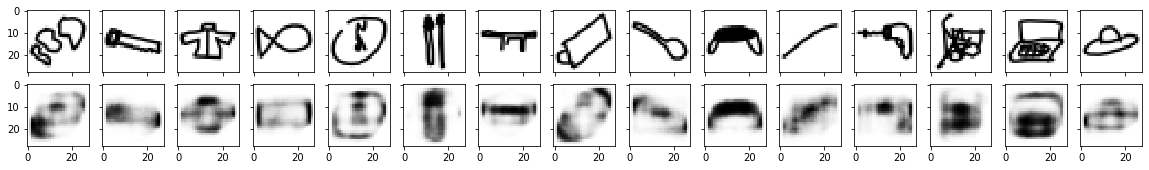

In [10]:
#Evaluation
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=15, 
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')


Image batch dimensions: torch.Size([15, 784])
Image label dimensions: torch.Size([15])


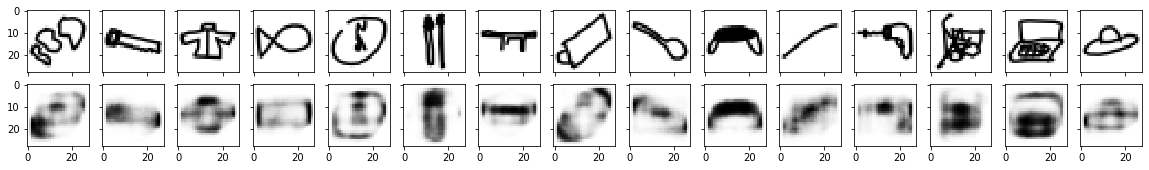

In [11]:
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=15, 
                         shuffle=True)

# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')